<a href="https://colab.research.google.com/github/AdrianSerbanescu/NLP_Notebooks/blob/main/Linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run in Colab to install and import local packages
!pip install spacy datasets pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datasets 
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Splits the annotations for src, tgt, mt into the types ("upos", "feats", "head", "deprel", "start_char", "end_char", "ner")
def split_annotation(data, type):
  return data[type]

In [ ]:
# Load the dataset
def load_data():
  data = datasets.load_dataset("GroNLP/divemt", split = "train")
  data.to_pandas().head()

  # Splitting the annotations into "upos", "feats", "head", "deprel", "start_char", "end_char", "ner"
  names_src = ["src_upos", "src_feats", "src_head", "src_deprel", "src_start_char", "src_end_char", "src_ner"]
  names_tgt = ["tgt_upos", "tgt_feats", "tgt_head", "tgt_deprel", "tgt_start_char", "tgt_end_char", "tgt_ner"]
  names_mt = ["mt_upos", "mt_feats", "mt_head", "mt_deprel", "mt_start_char", "mt_end_char", "mt_ner"]
  elem = ["upos", "feats", "head", "deprel", "start_char", "end_char", "ner"]
  for i in range(len(elem)):
    data = data.map(lambda x: {names_src[i]: split_annotation(x["src_annotations"], elem[i])})
    data = data.map(lambda x: {names_tgt[i]: split_annotation(x["tgt_annotations"], elem[i])})
    data = data.map(lambda x: {names_mt[i]: split_annotation(x["mt_annotations"], elem[i])})
  return data

In [ ]:
# Remove all the human-translated sentences.
def remove_ht(data):
  data = data.filter(lambda line: line["translation_type"] == "pe")
  print(data)
  return data

data = load_data()
data_mt = remove_ht(data)

Dataset({
    features: ['unit_id', 'flores_id', 'item_id', 'subject_id', 'lang_id', 'doc_id', 'task_type', 'translation_type', 'src_len_chr', 'mt_len_chr', 'tgt_len_chr', 'src_len_wrd', 'mt_len_wrd', 'tgt_len_wrd', 'edit_time', 'k_total', 'k_letter', 'k_digit', 'k_white', 'k_symbol', 'k_nav', 'k_erase', 'k_copy', 'k_cut', 'k_paste', 'k_do', 'n_pause_geq_300', 'len_pause_geq_300', 'n_pause_geq_1000', 'len_pause_geq_1000', 'event_time', 'num_annotations', 'last_modification_time', 'n_insert', 'n_delete', 'n_substitute', 'n_shift', 'tot_shifted_words', 'tot_edits', 'hter', 'cer', 'bleu', 'chrf', 'time_s', 'time_m', 'time_h', 'time_per_char', 'time_per_word', 'key_per_char', 'words_per_hour', 'words_per_minute', 'per_subject_visit_order', 'src_text', 'mt_text', 'tgt_text', 'aligned_edit', 'src_tokens', 'src_annotations', 'mt_tokens', 'mt_annotations', 'tgt_tokens', 'tgt_annotations', 'src_wmt22_qe', 'mt_wmt22_qe', 'src_upos', 'tgt_upos', 'mt_upos', 'src_feats', 'tgt_feats', 'mt_feats', 's

In [ ]:
# Create a baseline predictor using the mean and predict the validation targets using the validation features.
def baseline_prediction(features, target, validation_features):
  # Create a baseline model and fit it.
  baseline = DummyRegressor(strategy="mean")
  baseline.fit(features, target)
  # Predict the values for the validation features.
  predictions = baseline.predict(validation_features)
  return predictions, baseline

In [ ]:
# Create a linear regression predictor and predict the validation targets using the validation features.
def regressor_prediction(features, target, validation_features):
  # Create the linear regression model and fit it using training features.
  regressor = LinearRegression(n_jobs=-1)
  regressor.fit(features, target)
  # Predict the values for the validation features.
  predictions = regressor.predict(validation_features)
  return predictions, regressor

In [ ]:
# Create one hot encoded vectors for the subject, language and task
def create_one_hot_vectors(data):
  feature_data = pd.DataFrame()
  # Create vectors for the languages.
  language_vectors = pd.get_dummies(data['lang_id'])
  # Create vectors for the type of task (Google Translate vs. mBART)
  task_vectors = pd.get_dummies(data['task_type'])
  feature_data = pd.concat([feature_data, language_vectors, task_vectors], axis=1)
  return feature_data
  

In [ ]:
# Determine the proportion of bad tokens compared to the total tokens for each MT-translated sentence.
def determine_proportion_bad_tokens(data):
  bad_token_proportions = []
  bad_tokens = []
  for elem in data['mt_wmt22_qe']:
    cnt_total = 0
    cnt_bad = 0
    # Loop over the tags for the MT and count the total and bad tags.
    for tag in elem:
      cnt_total += 1
      if tag == 'BAD':
        cnt_bad += 1
    # A check, so the model does not break if there is no bad/ok token list.
    if cnt_total != 0:
      bad_token_proportions.append(cnt_bad/cnt_total)
      bad_tokens.append(cnt_bad)
    else:
      bad_token_proportions.append(0)
  return bad_token_proportions, bad_tokens


In [ ]:
def count_pos(pos):
  verbs = 0
  for elem in pos:
    if elem == 'VERB':
      verbs += 1
  return verbs

def count_verbs(data):
  data = data.map(lambda x: {"verb_counter": count_pos(x["src_upos"])})
  return data

data_temp = count_verbs(data_mt)
print(data_temp['verb_counter'])

[3, 4, 4, 4, 2, 1, 3, 5, 5, 2, 4, 2, 4, 2, 5, 2, 3, 1, 3, 2, 4, 3, 2, 3, 4, 5, 4, 7, 0, 4, 2, 3, 3, 3, 1, 1, 1, 1, 2, 1, 5, 4, 2, 2, 5, 2, 2, 4, 3, 1, 2, 2, 5, 4, 1, 3, 3, 1, 3, 1, 3, 4, 4, 2, 2, 1, 1, 2, 3, 2, 3, 3, 2, 3, 1, 2, 1, 3, 0, 0, 2, 0, 3, 1, 1, 2, 5, 3, 3, 4, 3, 4, 0, 2, 3, 1, 3, 2, 1, 9, 3, 0, 1, 2, 2, 2, 4, 3, 4, 3, 2, 0, 4, 4, 3, 4, 2, 2, 4, 2, 1, 5, 0, 2, 3, 1, 2, 3, 3, 1, 0, 2, 0, 2, 3, 2, 2, 2, 3, 7, 1, 3, 1, 4, 1, 2, 2, 4, 2, 3, 3, 5, 3, 2, 3, 2, 3, 5, 3, 1, 3, 2, 3, 2, 3, 0, 3, 4, 1, 2, 2, 1, 2, 2, 4, 5, 5, 0, 1, 2, 2, 1, 3, 1, 1, 3, 2, 3, 3, 2, 3, 4, 3, 3, 2, 1, 1, 1, 0, 1, 3, 2, 2, 4, 4, 3, 3, 5, 4, 5, 2, 2, 2, 5, 1, 2, 1, 2, 3, 2, 3, 2, 3, 2, 4, 7, 1, 5, 1, 2, 2, 2, 4, 2, 1, 1, 2, 3, 1, 2, 1, 2, 2, 4, 2, 3, 2, 4, 3, 3, 2, 2, 4, 1, 2, 3, 4, 0, 6, 1, 3, 1, 3, 6, 1, 1, 2, 2, 2, 5, 1, 3, 4, 1, 3, 2, 3, 2, 5, 1, 3, 5, 2, 4, 3, 3, 4, 3, 3, 2, 5, 2, 1, 1, 1, 5, 2, 2, 3, 1, 7, 5, 4, 7, 0, 3, 1, 2, 4, 2, 3, 3, 3, 5, 2, 2, 1, 1, 1, 1, 2, 4, 3, 1, 4, 1, 3, 1, 1, 3, 4, 4, 1, 

In [ ]:
# Determine what the complexity of a sentence is by counting the number of unique POS tags.
def complexity_pos(pos):
  complexity = len(np.unique(pos))
  return complexity

def count_complexity(data):
  data = data.map(lambda x: {"complexity": complexity_pos(x["src_upos"])})
  return data

data_temp = count_complexity(data_mt)
print(data_temp['complexity'])

[10, 8, 11, 12, 9, 9, 10, 12, 11, 10, 9, 10, 10, 8, 10, 9, 10, 13, 11, 10, 11, 10, 9, 11, 10, 8, 10, 11, 9, 11, 10, 10, 9, 9, 8, 10, 8, 11, 9, 9, 11, 11, 8, 9, 11, 10, 9, 10, 8, 8, 9, 7, 10, 10, 9, 9, 8, 9, 9, 7, 10, 10, 8, 10, 8, 9, 10, 8, 10, 11, 13, 10, 7, 12, 8, 8, 8, 12, 5, 9, 9, 7, 10, 10, 8, 8, 10, 10, 10, 9, 11, 12, 9, 8, 10, 9, 8, 11, 12, 12, 9, 7, 12, 9, 10, 9, 9, 10, 9, 12, 10, 8, 10, 11, 10, 12, 9, 10, 9, 9, 8, 10, 10, 8, 9, 9, 8, 10, 11, 10, 8, 9, 7, 11, 10, 10, 10, 8, 10, 11, 11, 11, 10, 10, 9, 12, 11, 11, 9, 13, 9, 9, 9, 9, 9, 8, 7, 11, 11, 10, 9, 9, 7, 8, 10, 7, 10, 11, 7, 9, 11, 10, 11, 10, 12, 14, 10, 7, 9, 9, 9, 7, 10, 9, 8, 9, 13, 11, 10, 10, 9, 11, 9, 11, 9, 11, 10, 10, 9, 12, 11, 6, 8, 10, 9, 10, 13, 12, 12, 9, 8, 10, 11, 10, 10, 10, 8, 8, 10, 11, 11, 6, 10, 8, 10, 11, 8, 10, 10, 7, 12, 11, 11, 8, 8, 6, 10, 8, 9, 8, 11, 7, 13, 9, 11, 8, 8, 10, 12, 9, 12, 6, 9, 7, 7, 9, 12, 9, 12, 10, 11, 8, 10, 7, 9, 10, 10, 9, 12, 12, 9, 10, 11, 9, 11, 8, 12, 11, 11, 9, 10, 12, 7

In [ ]:
# Format a feature dataset, so that all strings are one-hot encoded vectors and 
# all other relevant fields are added
def create_feature_data(data):
  feature_data = create_one_hot_vectors(data)
  src_len_wrd_df = pd.DataFrame(data['src_len_wrd'], columns = ['src_len_wrd'])
  k_total_df = pd.DataFrame(data['k_total'], columns = ['k_total'])
  feature_data = pd.concat([feature_data, src_len_wrd_df, k_total_df], axis=1)
  bad_token_proportions, bad_tokens = determine_proportion_bad_tokens(data)
  bad_token_df = pd.DataFrame(bad_token_proportions, columns = ['bad_token_proportions'])
  feature_data = pd.concat([feature_data, bad_token_df], axis=1)
  return feature_data, bad_tokens

full_features, bad_tokens = create_feature_data(data_mt)
edit_time_df = pd.DataFrame(data_mt['edit_time'], columns = ['edit_time'])
full_features = pd.concat([full_features, edit_time_df], axis = 1)
print(full_features)

      ara  ita  nld  tur  ukr  vie  pe1  pe2  src_len_wrd  k_total  \
0       0    0    0    1    0    0    1    0           21       50   
1       0    0    0    1    0    0    1    0           22        1   
2       0    0    0    1    0    0    1    0           22       69   
3       0    0    0    1    0    0    1    0           22       85   
4       0    0    0    1    0    0    1    0           15      109   
...   ...  ...  ...  ...  ...  ...  ...  ...          ...      ...   
5155    1    0    0    0    0    0    1    0           20        8   
5156    1    0    0    0    0    0    0    1           19       92   
5157    1    0    0    0    0    0    0    1           14      110   
5158    1    0    0    0    0    0    0    1           19      162   
5159    1    0    0    0    0    0    0    1           25      102   

      bad_token_proportions   edit_time  
0                  0.240000   18.135000  
1                  0.000000    7.469000  
2                  0.294118   28.

In [ ]:
# Predict the editing time using the linear model and a base model.
def predict_editing_time(train, test):
  features = train.drop(['edit_time'], axis=1)
  target = train['edit_time']
  test_features = test.drop(['edit_time'], axis=1)
  test_target = test['edit_time']
  # Do the baseline and linear regressor predictions.
  base_predict, baseline = baseline_prediction(features, target, test_features)
  regressor_predict, regressor = regressor_prediction(features, target, test_features)
  # Compute the metrics for the models.
  for metric in [mean_absolute_error, mean_squared_error]:
    print("Linear regressor", metric.__name__, metric(test_target, regressor_predict))
    print("Baseline", metric.__name__, metric(test_target, base_predict))
  MAE_regressor = mean_absolute_error(test_target, regressor_predict)
  MAE_baseline = mean_absolute_error(test_target, base_predict)
  return baseline, regressor, MAE_regressor, MAE_baseline

In [ ]:
# Printing the coefficients for all features in order to determine their relevance.
def determine_feature_importance(regressor):
  labels = regressor.feature_names_in_
  coefs = [regressor.coef_[i] for i in range(len(labels))]
  labels_df = pd.DataFrame(labels, columns = ['labels'])
  coefs_df = pd.DataFrame(coefs, columns = ['coefs'])
  feature_importance = pd.concat([labels_df, coefs_df], axis=1)
  print(feature_importance)
  return 

In [ ]:
# Run all the relevant parts for creating the linear model in one go.
def full_run():
  data = load_data()
  data_mt = remove_ht(data)
  full_features, bad_tokens = create_feature_data(data_mt)
  data_mt = count_verbs(data_mt)
  data_mt = count_complexity(data_mt)
  verbs_df = pd.DataFrame(data_mt['verb_counter'], columns = ['verb_counter'])
  complexity_df = pd.DataFrame(data_mt['complexity'], columns = ['complexity'])
  edit_time_df = pd.DataFrame(data_mt['edit_time'], columns = ['edit_time'])
  full_features = pd.concat([full_features, verbs_df, complexity_df, edit_time_df], axis = 1)
  print(full_features)
  kf = KFold(n_splits=5, shuffle = True)
  MAE_regressor_list = []
  MAE_baseline_list = []
  for train, test in kf.split(full_features):
    baseline, regressor, MAE_regressor, MAE_baseline = predict_editing_time(full_features.iloc[train], full_features.iloc[test])
    MAE_regressor_list.append(MAE_regressor)
    MAE_baseline_list.append(MAE_baseline)
    determine_feature_importance(regressor)
  print(MAE_regressor_list)
  print(np.mean(MAE_regressor_list))
  print(np.std(MAE_regressor_list))
  print(MAE_baseline_list)
  print(np.mean(MAE_baseline_list))
  print(np.std(MAE_baseline_list))
  return

full_run()

Dataset({
    features: ['unit_id', 'flores_id', 'item_id', 'subject_id', 'lang_id', 'doc_id', 'task_type', 'translation_type', 'src_len_chr', 'mt_len_chr', 'tgt_len_chr', 'src_len_wrd', 'mt_len_wrd', 'tgt_len_wrd', 'edit_time', 'k_total', 'k_letter', 'k_digit', 'k_white', 'k_symbol', 'k_nav', 'k_erase', 'k_copy', 'k_cut', 'k_paste', 'k_do', 'n_pause_geq_300', 'len_pause_geq_300', 'n_pause_geq_1000', 'len_pause_geq_1000', 'event_time', 'num_annotations', 'last_modification_time', 'n_insert', 'n_delete', 'n_substitute', 'n_shift', 'tot_shifted_words', 'tot_edits', 'hter', 'cer', 'bleu', 'chrf', 'time_s', 'time_m', 'time_h', 'time_per_char', 'time_per_word', 'key_per_char', 'words_per_hour', 'words_per_minute', 'per_subject_visit_order', 'src_text', 'mt_text', 'tgt_text', 'aligned_edit', 'src_tokens', 'src_annotations', 'mt_tokens', 'mt_annotations', 'tgt_tokens', 'tgt_annotations', 'src_wmt22_qe', 'mt_wmt22_qe', 'src_upos', 'tgt_upos', 'mt_upos', 'src_feats', 'tgt_feats', 'mt_feats', 's

      ara  ita  nld  tur  ukr  vie  pe1  pe2  src_len_wrd  k_total  \
0       0    0    0    1    0    0    1    0           21       50   
1       0    0    0    1    0    0    1    0           22        1   
2       0    0    0    1    0    0    1    0           22       69   
3       0    0    0    1    0    0    1    0           22       85   
4       0    0    0    1    0    0    1    0           15      109   
...   ...  ...  ...  ...  ...  ...  ...  ...          ...      ...   
5155    1    0    0    0    0    0    1    0           20        8   
5156    1    0    0    0    0    0    0    1           19       92   
5157    1    0    0    0    0    0    0    1           14      110   
5158    1    0    0    0    0    0    0    1           19      162   
5159    1    0    0    0    0    0    0    1           25      102   

      bad_token_proportions  verb_counter  complexity   edit_time  
0                  0.240000             3          10   18.135000  
1                  0.00

In [ ]:
# Analyse the amount of errors versus the editing time.
def errors_vs_editing_time(data, bad_tokens):
  # Determine how often each amount of errors occurs + the total editing time per amount of errors.
  counter_errors = np.zeros(max(bad_tokens)+1)
  time_per_errors = np.zeros(max(bad_tokens)+1)
  for i in range(len(data)):
    counter_errors[bad_tokens[i]] += 1
    time_per_errors[bad_tokens[i]] += data['edit_time'][i]
  
  # Compute the average editing time per amount of errors
  average_time_per_error = np.zeros(max(bad_tokens)+1)
  for i in range(len(counter_errors)):
    if counter_errors[i] == 0:
      average_time_per_error[i] = 0
    else:
      average_time_per_error[i] = time_per_errors[i]/counter_errors[i]
  return counter_errors, time_per_errors, average_time_per_error

proportion_bad_tokens, bad_tokens = determine_proportion_bad_tokens(data_mt)
counter_errors, time_per_errors, average_time_per_error = errors_vs_editing_time(data_mt, bad_tokens)

# Create a dataframe for the output.
counter_df = pd.DataFrame(counter_errors, columns = ['counter_errors'])
time_df = pd.DataFrame(time_per_errors, columns = ['time'])
avg_time_df = pd.DataFrame(average_time_per_error, columns = ['avg_time'])
editing_time_vs_errors = pd.concat([counter_df, time_df, avg_time_df], axis=1)
print(editing_time_vs_errors)

    counter_errors          time    avg_time
0            554.0  17979.770019   32.454459
1            417.0  18152.754025   43.531784
2            389.0  21626.064034   55.593995
3            374.0  26362.529066   70.488046
4            382.0  28266.161954   73.995188
5            394.0  40631.253238  103.125008
6            322.0  33706.074932  104.677251
7            345.0  33822.043917   98.034910
8            296.0  33952.622919  114.704807
9            257.0  36674.864862  142.703754
10           236.0  39442.804934  167.130529
11           184.0  25785.965948  140.141119
12           185.0  26732.901918  144.502173
13           141.0  21001.167084  148.944447
14           124.0  30184.005032  243.419395
15           106.0  19119.943966  180.376830
16            78.0  14924.865948  191.344435
17            77.0  13011.578915  168.981544
18            59.0  10552.853977  178.861932
19            38.0  10108.658077  266.017318
20            40.0   9142.986027  228.574651
21        

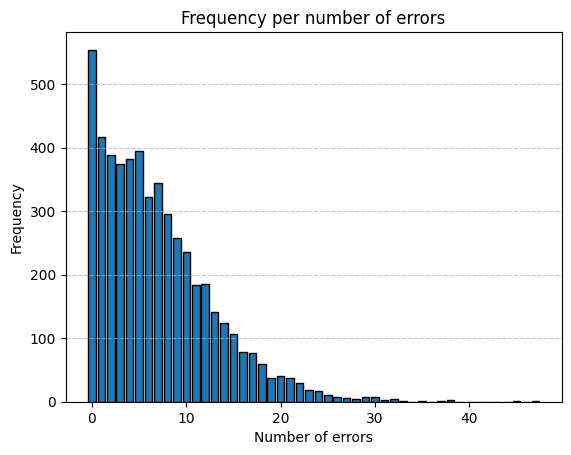

In [ ]:
import matplotlib.pyplot as plt
plt.bar(np.arange(max(bad_tokens) + 1), counter_errors, edgecolor='black')
plt.xlabel('Number of errors')
plt.ylabel(f'Frequency')
plt.title(f'Frequency per number of errors')
# plt.xticks(rotation=90)  # set rotation to 90 degrees
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

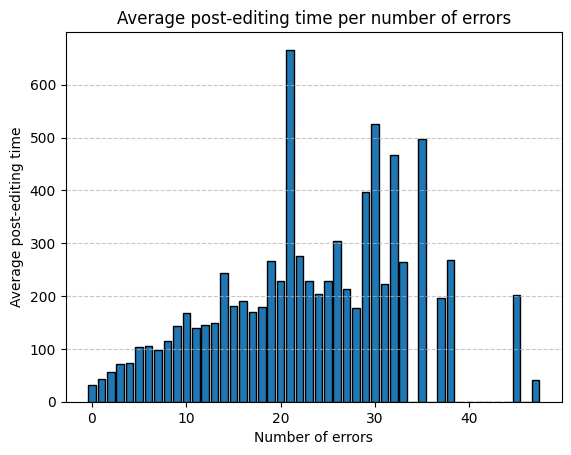

In [ ]:
plt.bar(np.arange(max(bad_tokens) + 1), average_time_per_error, edgecolor='black')
plt.xlabel('Number of errors')
plt.ylabel(f'Average post-editing time')
plt.title(f'Average post-editing time per number of errors')
# plt.xticks(rotation=90)  # set rotation to 90 degrees
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()